# Introduction
Armed with the basic prerequisite knowledge of deep learning, we shall tackle a problem using a multilayer perceptron (MLP).

The term, MLP, is used to distinguish itself, a feedforward artificial neural network, from other deep learning models we will learn about in the future.

This notebook is done with PyTorch. A version done using Tensorflow is available [here](https://colab.research.google.com/drive/1XCsfqw0NiFtN368vm4j1ssT3x3v_g6cM?usp=sharing).

# The Problem
Given some temperature, humidity, and wind speed, can we predict the precipitation percentage?

# Set Seed
To ensure this notebook is deterministic, we will set the random seed.

In [ ]:
import torch
import random
import numpy as np

torch.manual_seed(1) # 1 b/c 0 performs particularly bad
random.seed(0)
np.random.seed(0)

# Get Data
Here, we will fetch and load the data into a tensor that we will use for training.

Data source: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification

In [ ]:
import urllib

import pandas as pd

data_url = "https://g-2aaf39.eeb47.a567.data.globus.org/weather_classification_data.csv"
data_buffer = urllib.request.urlopen(data_url)

df = pd.read_csv(data_buffer)

In [ ]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Let's retain only the columns we need.

In [ ]:
X_df = df[['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)']]
Y_df = df['Weather Type']

Then, only keep the rows where the weather type is rainy or sunny.

In [ ]:
X_df = X_df.loc[(df['Weather Type']=='Rainy') | (df['Weather Type']=='Sunny')]
Y_df = Y_df.loc[(df['Weather Type']=='Rainy') | (df['Weather Type']=='Sunny')]

Transform $Y$ labels to binary labels.

In [ ]:
Y_df[Y_df == 'Rainy'] = 0
Y_df[Y_df == 'Sunny'] = 1

Y_df = Y_df.astype(int)

In [ ]:
X_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%)
0,14.0,73,9.5,82.0
2,30.0,64,7.0,16.0
3,38.0,83,1.5,82.0
4,27.0,74,17.0,66.0
9,28.0,74,8.5,107.0


In [ ]:
Y_df.head()

,Weather Type
0,0
2,1
3,1
4,0
9,1


Recall that $X$ has shape $n_x\times m$, and $Y$ has shape $n_y\times m$. However, one should always check the convention of the library that they use. In the case of PyTorch, a linear layer expects an input of $m\times n_\text{in}$ and has an output of $m\times n_\text{out}$.

Thus, columns are features and rows are each observation, and we can convert the dataframes into tensors directly.

Note that we convert Y from an `int64` to a `double`/`torch.float64` to match the precision of `X`. Then, we `squeeze` the tensor to make `Y` one-dimensional.

In [ ]:
X = X_df.values
Y = Y_df.values.reshape(-1, 1)

X = torch.tensor(X)
Y = torch.tensor(Y).double().squeeze()

In [ ]:
X

tensor([[14.0000, 73.0000,  9.5000, 82.0000],
        [30.0000, 64.0000,  7.0000, 16.0000],
        [38.0000, 83.0000,  1.5000, 82.0000],
        ...,
        [31.0000, 24.0000,  8.0000,  5.0000],
        [10.0000, 74.0000, 14.5000, 71.0000],
        [-5.0000, 38.0000,  0.0000, 92.0000]], dtype=torch.float64)

In [ ]:
X.shape

torch.Size([6600, 4])

In [ ]:
Y

tensor([0., 1., 1.,  ..., 1., 0., 0.], dtype=torch.float64)

In [ ]:
Y.shape

torch.Size([6600])

# Normalize and Split Data
We shall normalize our data using minmax scaling. Recall, it is given by: $$x'=\frac{x-x_{\text{min}}}{x_{\text{max}}-x_{\text{min}}}$$

Note that when finding the min and max for $X$, we must define that we are taking this metric along the first axis. Thus, a $1\times3$ mean will be produced from a $13200\times3$ $X$.

In [ ]:
X_max = X.max(axis=0).values
X_min = X.min(axis=0).values
Y_max = Y.max().double()
Y_min = Y.min().double()

Xp = (X - X_min) / (X_max - X_min)
Yp = (Y - Y_min) / (Y_max - Y_min)

Now, let's split our data.

In [ ]:
m = len(X)
split_n = [int(n) for n in [m*p for p in [0.8*0.8, 0.8*0.2, 0.2]]]

X_train, X_val, X_test = torch.split(Xp, split_n)
Y_train, Y_val, Y_test = torch.split(Yp, split_n)

# Create Model Class
Let's start with a basic model, with one hidden layer of 2 layers.

Note that we convert the stack of layers to have parameters of type `double` to match the types of our data. The default type of parameters are `float32`.

In [ ]:
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(4, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        ).double()

    def forward(self, x):
        return self.stack(x).squeeze()

# Train and Test

## Using PyTorch

### Create training loop
PyTorch has no default equivalent to TensorFlow Keras' `model.fit`. Thus, we must define one.

In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
from torcheval.metrics import BinaryAccuracy

def train(model, X_train, Y_train, X_val, Y_val, epochs, loss_fn, optimizer):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    metric = BinaryAccuracy()

    for epoch in range(epochs+1):
        # set model to train mode
        model.train()

        # forward prop
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, Y_train)

        # back prop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        metric.update(y_pred, Y_train)
        train_acc = metric.compute()
        train_accs.append(train_acc.item())
        train_losses.append(train_loss.item())
        metric.reset()

        with torch.no_grad():
            model.eval()
            y_pred = model(X_val)
            val_loss = loss_fn(y_pred, Y_val)

            metric.update(y_pred, Y_val)
            val_acc = metric.compute()
            val_accs.append(val_acc.item())
            val_losses.append(val_loss.item())
            metric.reset()

            if epoch % (epochs/10) == 0:
                print(f"Epoch: {epoch:<4}, Train Acc: {train_acc.item():>7f}, "\
                f"Train Loss: {train_loss.item():>7f}; "\
                f"Val Acc: {val_acc.item():>7f}, Val Loss: {val_loss.item():>7f}")

    return [train_losses, val_losses, train_accs, val_accs]

### Run Training Loop

In [ ]:
# define hyperparameters
EPOCHS = int(1e3)

# create model instance
model = Model()

model

Model(
  (stack): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
# define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# train
train_losses, val_losses, train_accs, val_accs = train(model, X_train, Y_train, X_val, Y_val, EPOCHS, loss_fn, optimizer)

Epoch: 0   , Train Acc: 0.511127, Train Loss: 0.262052; Val Acc: 0.480114, Val Loss: 0.269401
Epoch: 100 , Train Acc: 0.511127, Train Loss: 0.249092; Val Acc: 0.480114, Val Loss: 0.253098
Epoch: 200 , Train Acc: 0.850852, Train Loss: 0.232807; Val Acc: 0.839962, Val Loss: 0.233162
Epoch: 300 , Train Acc: 0.887074, Train Loss: 0.215018; Val Acc: 0.879735, Val Loss: 0.214587
Epoch: 400 , Train Acc: 0.885890, Train Loss: 0.192489; Val Acc: 0.875947, Val Loss: 0.192449
Epoch: 500 , Train Acc: 0.885890, Train Loss: 0.170338; Val Acc: 0.875947, Val Loss: 0.170958
Epoch: 600 , Train Acc: 0.886600, Train Loss: 0.153592; Val Acc: 0.875947, Val Loss: 0.154772
Epoch: 700 , Train Acc: 0.887074, Train Loss: 0.140997; Val Acc: 0.876894, Val Loss: 0.142841
Epoch: 800 , Train Acc: 0.887074, Train Loss: 0.131413; Val Acc: 0.877841, Val Loss: 0.133953
Epoch: 900 , Train Acc: 0.887784, Train Loss: 0.124060; Val Acc: 0.878788, Val Loss: 0.127260
Epoch: 1000, Train Acc: 0.887311, Train Loss: 0.118319; Val 

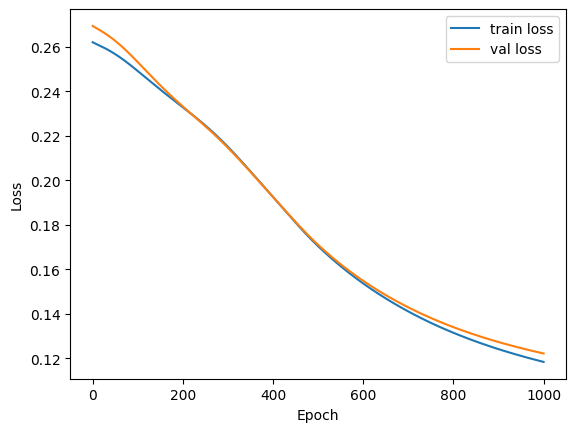

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

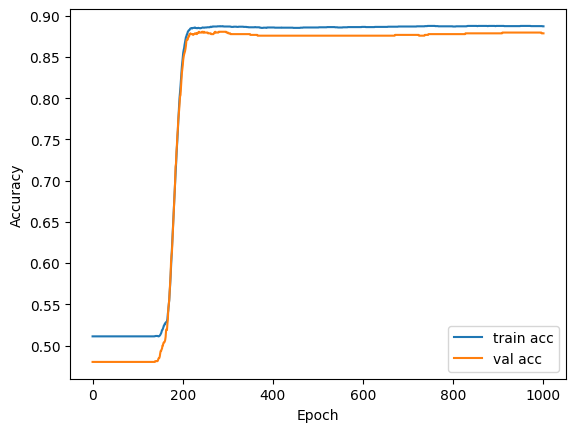

In [ ]:
plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Test

In [ ]:
y_pred = model(X_test)
loss = loss_fn(y_pred, Y_test)

metric = BinaryAccuracy()
metric.update(y_pred, Y_test)
acc = metric.compute()

print(f"Test Loss: {loss.item():>7f}, Test Acc: {acc.item():>7f}")

Test Loss: 0.123011, Test Acc: 0.884848


## Using PyTorch Lightning
PyTorch Lightning is a library that provides a high-level interface for PyTorch. One of its features is a default `fit` loop, similar to what Tensorflow Keras provides.

In [ ]:
# !pip install lightning

In [ ]:
import shutil

shutil.rmtree("lightning_logs")

FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs'

In [ ]:
import lightning as L

class LitModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(4, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        ).double()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.stack(x).squeeze()
        loss = nn.functional.mse_loss(y_pred, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.stack(x).squeeze()
        loss = nn.functional.mse_loss(y_pred, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.stack(x).squeeze()
        loss = nn.functional.mse_loss(y_pred, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, Y_train), batch_size = len(Y_train))

    def val_dataloader(self):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, Y_val),  batch_size=len(Y_val))

    def test_dataloader(self):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, Y_test),  batch_size=len(Y_test))

In [ ]:
EPOCHS = 1000

model = LitModel()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, Y_train), batch_size = len(Y_train))
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, Y_val),  batch_size=len(Y_val))

trainer = L.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)
trainer.fit(model)

In [ ]:
trainer.test()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/